# REIT

- MSCI US REIT Custom Capped Index (BBRE)
- IFGL

In [1]:
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import pandas as pd
import polars as pl
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from dividends_reinvestment_return import dividends_reinvestment_return

In [2]:
path = '../../../data/row/usd_jpy_rate.csv'
usd_jpy_rate = pl.read_csv(path)
usd_jpy_rate = usd_jpy_rate.with_columns(
    pl.col('date').cast(pl.Date)
).rename(
    {'date': 'Date'}
).drop_nulls()
usd_jpy_rate.head()

Date,usd_jpy_rate
date,f64
1973-01-04,301.1
1973-01-05,301.15
1973-01-08,302.25
1973-01-09,302.4
1973-01-10,301.55


## BBRE

In [25]:
ticker = 'BBRE'
tiskers = yf.Ticker(ticker)
historical_data = tiskers.history(period='max')

def get_close_and_dividends(data):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'],
        'Dividends': data['Dividends'],
    })
    return df


df = get_close_and_dividends(historical_data)
df = df.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
df = df.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
df = dividends_reinvestment_return(df, initial_shares=10000)

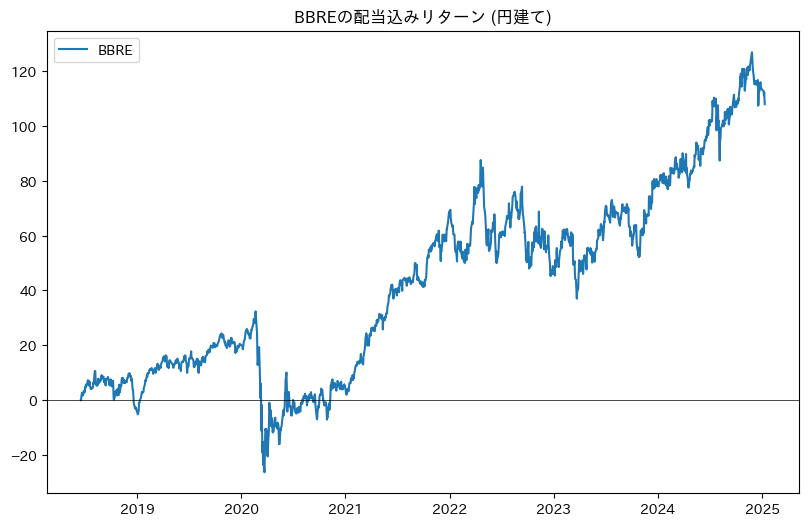

In [28]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['Return'], label=f'{ticker}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'{ticker}の配当込みリターン (円建て)')
ax.legend()

In [27]:
cagr = (df['Value'][-1] / df['Value'][0]) ** (250 / len(df)) - 1

sd = np.std(df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 12.560%
Volatility: 26.526%
Sharpe Ratio: 0.473


## IFGL

In [29]:
ticker = 'IFGL'
tiskers = yf.Ticker(ticker)
historical_data = tiskers.history(period='max')

def get_close_and_dividends(data):
    df = pl.DataFrame({
        'Date': data.index,
        'Close': data['Close'],
        'Dividends': data['Dividends'],
    })
    return df


df = get_close_and_dividends(historical_data)
df = df.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
df = df.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
df = dividends_reinvestment_return(df, initial_shares=10000)

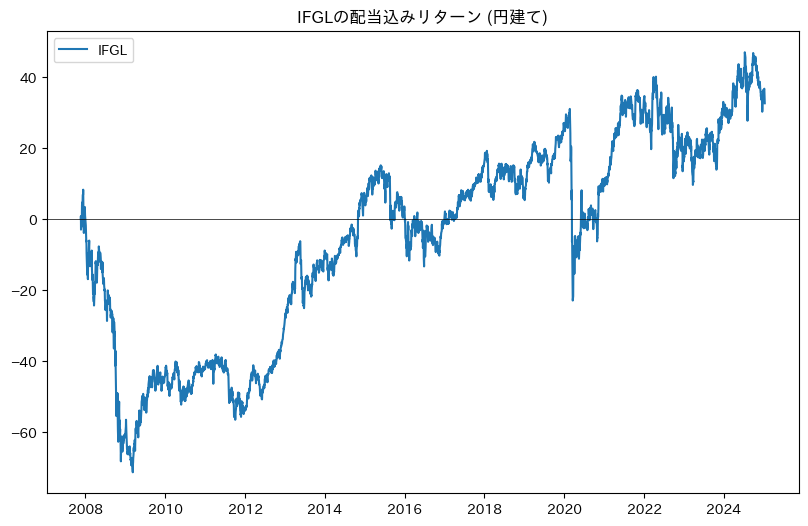

In [31]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['Return'], label=f'{ticker}')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title(f'{ticker}の配当込みリターン (円建て)')
ax.legend()

In [24]:
cagr = (df['Value'][-1] / df['Value'][0]) ** (250 / len(df)) - 1

sd = np.std(df['Close'].log().diff().fill_null(0).to_numpy())
sd_yearly = sd * np.sqrt(250)

sr = cagr / sd_yearly

print(f'CAGR: {cagr:.3%}')
print(f'Volatility: {sd_yearly:.3%}')
print(f'Sharpe Ratio: {sr:.3f}')

CAGR: 1.760%
Volatility: 25.122%
Sharpe Ratio: 0.070


## 地域比率

In [323]:
# america, asia_pasific, emea
america = 5.63
asia_pasific = 59.4
emea = 34.95
x = np.array([america, asia_pasific, emea])
mean_region = np.mean(x)
deviation_squared_sum = (america - mean_region)**2 + (asia_pasific - mean_region)**2 + (emea - mean_region)
region_variance = deviation_squared_sum / 3
print(f'偏差２乗和: {deviation_squared_sum:.2f}')

偏差２乗和: 1448.55


## リバランス

In [73]:
ticker = ['BBRE', 'IFGL', 'JPY=X']
tiskers = yf.Tickers(ticker)
historical_data = tiskers.history(period='max')
historical_data.dropna(inplace=True)

def get_close_and_dividends(data, ticker):
    df = pl.DataFrame({
            'Date': data.index,
            'Close': data['Close'][f'{ticker}'] * data['Close'][f'JPY=X'],
            'Dividends': data['Dividends'][f'{ticker}'] * data['Close'][f'JPY=X'],
    })
    return df

df = pl.DataFrame({
    'Date': historical_data.index,
    'BBRE_close': historical_data['Close']['BBRE'] * historical_data['Close']['JPY=X'],
    'BBRE_dividends': historical_data['Dividends']['BBRE'] * historical_data['Close']['JPY=X'],
    'IFGL_close': historical_data['Close']['IFGL'] * historical_data['Close']['JPY=X'],
    'IFGL_dividends': historical_data['Dividends']['IFGL'] * historical_data['Close']['JPY=X'],
})

bbre = get_close_and_dividends(historical_data, ticker='BBRE')
bbre = bbre.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
bbre = bbre.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
bbre = dividends_reinvestment_return(bbre, initial_shares=10000)

ifgl = get_close_and_dividends(historical_data, ticker='IFGL')
ifgl = ifgl.with_columns(pl.col('Date').cast(pl.Date)).join(usd_jpy_rate, on='Date', how='inner')
ifgl = ifgl.with_columns(
    (pl.col('Close') * pl.col('usd_jpy_rate')).alias('Close')
)
ifgl = dividends_reinvestment_return(ifgl, initial_shares=10000)

[*********************100%***********************]  3 of 3 completed


In [74]:
df.head()

Date,BBRE_close,BBRE_dividends,IFGL_close,IFGL_dividends
datetime[ns],f64,f64,f64,f64
2018-06-18 00:00:00,6878.299923,0.0,2564.174387,0.0
2018-06-19 00:00:00,6883.980472,0.0,2530.35107,44.826166
2018-06-20 00:00:00,6943.410672,0.0,2537.445484,0.0
2018-06-21 00:00:00,6991.20467,0.0,2536.998498,0.0
2018-06-22 00:00:00,7039.395331,0.0,2546.775906,0.0


In [75]:
df['BBRE_dividends'][1]

0.0

In [83]:
i = 2
bbre_shares[i-1]

5.0

In [87]:
# 初期値
init_val = 100000
# BBREのリバランス区間
bbre_weight = 0.3
bbre_max_rate = bbre_weight + 0.05
bbre_min_rate = bbre_weight - 0.05

bbre_shares = []
bbre_navs = []
bbre_weights = []
ifgl_shares = []
ifgl_navs = []
total_navs = []
cashes = []

# 初日のポートフォリオ
# BBREの初期持ち株数
bbre_init_share = init_val * bbre_max_rate // df['BBRE_close'][0]
bbre_shares.append(bbre_init_share)
# BBREの初期NAV
bbre_init_nav = bbre_init_share * df['BBRE_close'][0]
bbre_navs.append(bbre_init_nav)
# IFGLの初期持ち株数
ifgl_init_share = (init_val - bbre_init_nav) // df['IFGL_close'][0]
ifgl_shares.append(ifgl_init_share)
# IFGLの初期NAV
ifgl_init_nav = ifgl_init_share * df['IFGL_close'][0]
ifgl_navs.append(ifgl_init_nav)
# Cash
cash = init_val - bbre_init_nav - ifgl_init_nav
cashes.append(cash)
# 総NAV
total_init_nav = bbre_init_nav + ifgl_init_nav + cash
total_navs.append(total_init_nav)
# BBREのウェイト
bbre_weights.append(bbre_init_nav / total_init_nav)

for i in range(1, len(df)):
    # 配当金 (前日の持ち株数 * 配当金)
    bbre_dividends = bbre_shares[i-1] * df['BBRE_dividends'][i]
    ifgl_dividends = ifgl_shares[i-1] * df['IFGL_dividends'][i]
    # 前期のキャッシュに配当金を追加
    cash_in_div = cashes[i-1] + bbre_dividends + ifgl_dividends
    # BBREをいくつ買えるか
    bbre_share_cash = cash_in_div // df['BBRE_close'][i]
    # BBREを買うために使ったキャッシュ
    cash_for_bbre = bbre_share_cash * df['BBRE_close'][i]
    # IFGLをいくつ買えるか
    ifgl_share_cash = (cash_in_div - cash_for_bbre) // df['IFGL_close'][i]
    # IFGLを買ったあとのキャッシュ
    cash_i = ifgl_share_cash * df['IFGL_close'][i]
    cashes.append(cash_i)
    # 配当再投資 (前日の持ち株数に配当金 / 終値を追加)
    bbre_share_re_inv = bbre_shares[i-1] + bbre_share_cash
    ifgl_share_re_inv = ifgl_shares[i-1] + ifgl_share_cash

    # 再投資後の持ち株数
    bbre_share = bbre_shares[i-1] + bbre_share_re_inv
    ifgl_share = ifgl_shares[i-1] + ifgl_share_re_inv

    # 評価額
    bbre_nav = bbre_share * df['BBRE_close'][i]
    ifgl_nav = ifgl_share * df['IFGL_close'][i]
    total_nav = bbre_nav + ifgl_nav + cash_i
    # BBREのウェイト
    bbre_weight = bbre_nav / total_nav

    # BBREのウェイトが区間を超える場合
    if bbre_weight > bbre_max_rate:
        print('rebalance at ', df['Date'][i])

        # BBREを売却
        # BBREの持ち株数の目標
        bbre_target_share = total_nav * bbre_max_rate // df['BBRE_close'][i]
        # BBREの売却数は持ち株数 - 目標持ち株数
        bbre_share_for_sell = bbre_share_re_inv - bbre_target_share

    # BBREのウェイトが区間を下回る場合
    elif bbre_weight < bbre_min_rate:
        print('rebalance at ', df['Date'][i])

    bbre_shares.append(bbre_share_re_inv)
    bbre_navs.append(bbre_nav)
    ifgl_shares.append(ifgl_share_re_inv)
    ifgl_navs.append(ifgl_nav)
    total_navs.append(total_nav)
    bbre_weights.append(bbre_weight)

rebalance_df = pl.DataFrame({
    'Date': df['Date'],
    'BBRE_shares': bbre_shares,
    'BBRE_navs': bbre_navs,
    'IFGL_shares': ifgl_shares,
    'IFGL_navs': ifgl_navs,
    'Total_navs': total_navs,
    'BBRE_weights': bbre_weights,
    'cash': cashes,
})

rebalance_df = rebalance_df.with_columns([
    pl.col('Total_navs').log().alias('Total_navs_log'),
])
rebalance_df = rebalance_df.with_columns([
    (pl.col('Total_navs_log') - rebalance_df['Total_navs_log'][0]).alias('LogReturn'),
])
rebalance_df = rebalance_df.with_columns([
    ((pl.col('LogReturn').exp() - 1)*100).alias('Return'),
])

rebalance at  2018-06-27 00:00:00
rebalance at  2018-06-28 00:00:00
rebalance at  2018-06-29 00:00:00
rebalance at  2018-07-02 00:00:00
rebalance at  2018-07-03 00:00:00
rebalance at  2018-07-05 00:00:00
rebalance at  2018-07-06 00:00:00
rebalance at  2018-07-09 00:00:00
rebalance at  2018-07-10 00:00:00
rebalance at  2018-07-11 00:00:00
rebalance at  2018-07-12 00:00:00
rebalance at  2018-07-13 00:00:00
rebalance at  2018-07-16 00:00:00
rebalance at  2018-07-17 00:00:00
rebalance at  2018-07-19 00:00:00
rebalance at  2018-07-23 00:00:00
rebalance at  2018-07-24 00:00:00
rebalance at  2018-07-31 00:00:00
rebalance at  2018-08-01 00:00:00
rebalance at  2018-08-02 00:00:00
rebalance at  2018-08-03 00:00:00
rebalance at  2018-08-06 00:00:00
rebalance at  2018-08-07 00:00:00
rebalance at  2018-08-08 00:00:00
rebalance at  2018-08-09 00:00:00
rebalance at  2018-08-10 00:00:00
rebalance at  2018-08-13 00:00:00
rebalance at  2018-08-14 00:00:00
rebalance at  2018-08-15 00:00:00
rebalance at  

In [88]:
rebalance_df.head()

Date,BBRE_shares,BBRE_navs,IFGL_shares,IFGL_navs,Total_navs,BBRE_weights,cash,Total_navs_log,LogReturn,Return
datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2018-06-18 00:00:00,5.0,34391.499616,25.0,64104.359667,100000.0,0.343915,1504.140717,11.512925,0.0,0.0
2018-06-19 00:00:00,5.0,68839.804716,26.0,129047.904547,200418.060332,0.343481,2530.35107,12.208161,0.695235,100.41806
2018-06-20 00:00:00,5.0,69434.106723,26.0,131947.165145,201381.271868,0.344789,0.0,12.212955,0.70003,101.381272
2018-06-21 00:00:00,5.0,69912.046703,26.0,131923.921912,201835.968615,0.346381,0.0,12.215211,0.702285,101.835969
2018-06-22 00:00:00,5.0,70393.953311,26.0,132432.347088,202826.300399,0.347065,0.0,12.220105,0.70718,102.8263


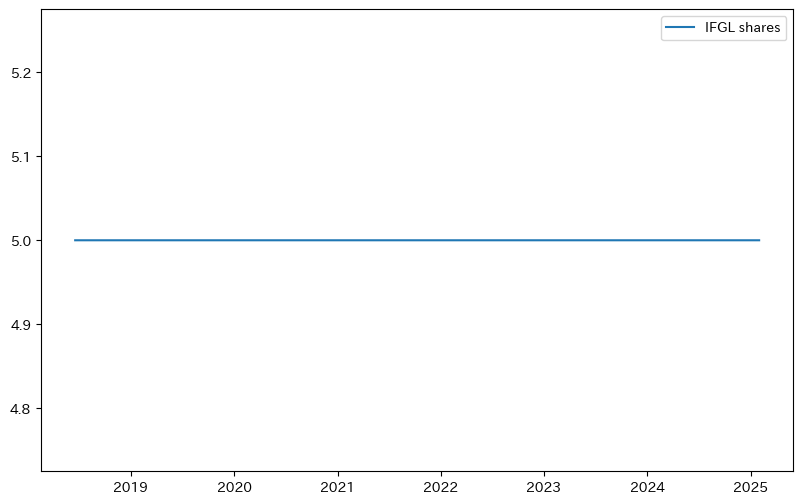

In [89]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(rebalance_df['Date'], rebalance_df['BBRE_shares'], label='IFGL shares')
# ax.plot(rebalance_df['Date'], rebalance_df['IFGL_shares'], label='BBRE shares')
ax.legend()

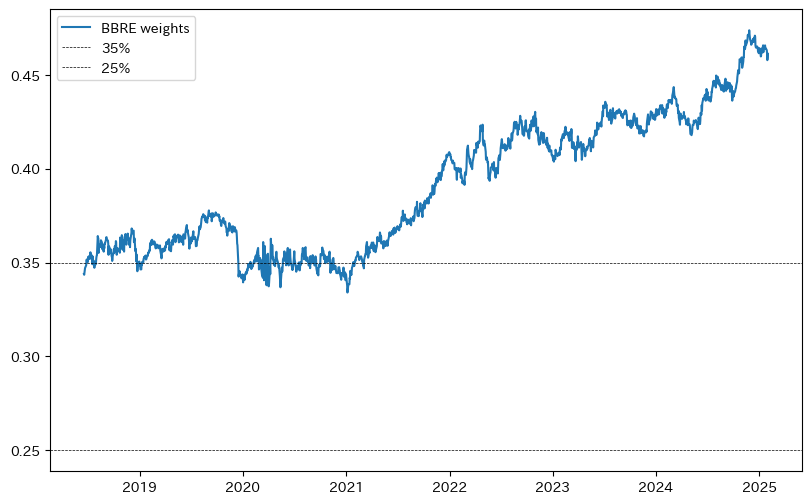

In [90]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(rebalance_df['Date'], rebalance_df['BBRE_weights'], label='BBRE weights')
ax.axhline(bbre_max_rate, color='black', linewidth=0.5, linestyle='--', label=f'{bbre_max_rate:.0%}')
ax.axhline(bbre_min_rate, color='black', linewidth=0.5, linestyle='--', label=f'{bbre_min_rate:.0%}')
ax.legend()

In [91]:
buy_and_hold = pl.DataFrame({
    'Date': df['Date'],
    'BBRE_navs': df['BBRE_close']*bbre_init_share,
    'IFGL_navs': df['IFGL_close']*ifgl_init_share,
    'Total_navs': df['BBRE_close']*bbre_init_share + df['IFGL_close']*ifgl_init_share,
})
buy_and_hold = buy_and_hold.with_columns([
    pl.col('Total_navs').log().alias('Total_navs_log'),
])
buy_and_hold = buy_and_hold.with_columns([
    (pl.col('Total_navs_log') - buy_and_hold['Total_navs_log'][0]).alias('LogReturn'),
])
buy_and_hold = buy_and_hold.with_columns([
    ((pl.col('LogReturn').exp() - 1)*100).alias('Return'),
])

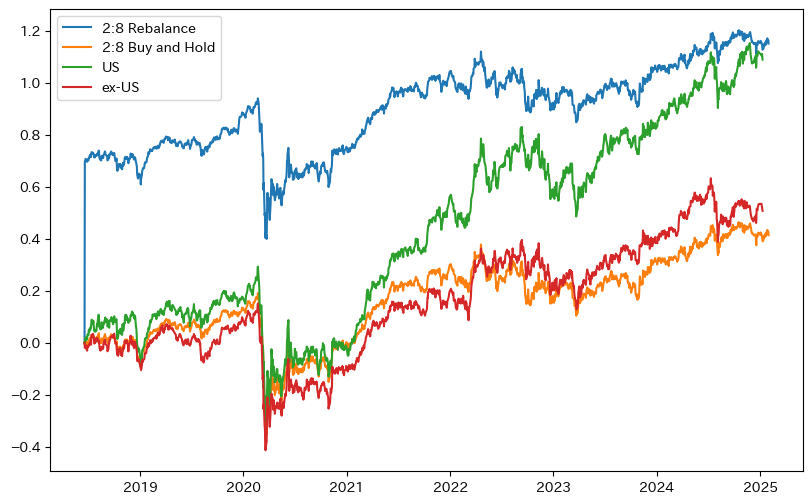

In [92]:
bbre_init_nav_log = np.log(bbre_init_nav)
ifgl_init_nav_log = np.log(ifgl_init_nav)

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(rebalance_df['Date'], rebalance_df['LogReturn'], label='2:8 Rebalance')
ax.plot(rebalance_df['Date'], buy_and_hold['LogReturn'], label='2:8 Buy and Hold')
ax.plot(bbre['Date'], bbre['LogReturn'], label='US')
ax.plot(ifgl['Date'], ifgl['LogReturn'], label='ex-US')
ax.legend()

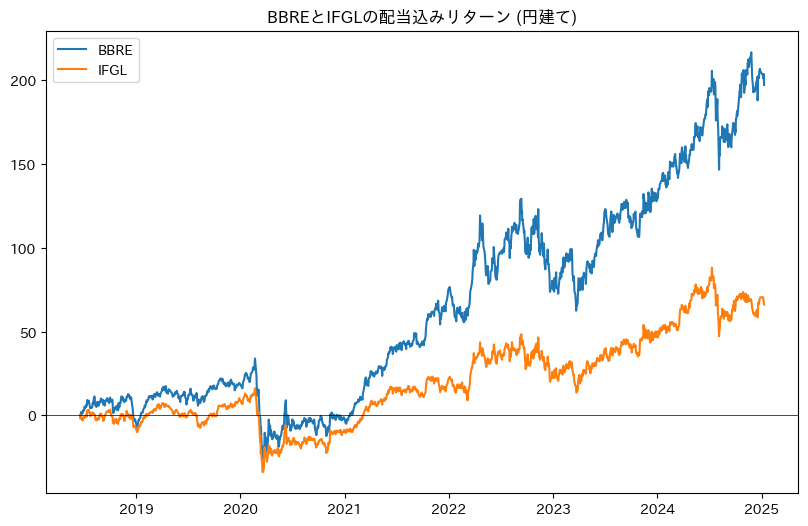

In [190]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(bbre['Date'], bbre['Return'], label='BBRE')
ax.plot(ifgl['Date'], ifgl['Return'], label='IFGL')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title('BBREとIFGLの配当込みリターン (円建て)')
ax.legend()

## 効率的フロンティア

In [332]:
tiskers = ['IYR', 'IFGL', 'JPY=X']
historical_data = yf.download(tiskers, period='max', interval='1mo')
df = pl.DataFrame({
    'Date': historical_data.index,
    'IYR_close': historical_data['Close']['IYR'] * historical_data['Close']['JPY=X'],
    'IFGL_close': historical_data['Close']['IFGL'] * historical_data['Close']['JPY=X'],
}).with_columns(
    pl.col('Date').cast(pl.Date),
    pl.col('IYR_close').log().alias('IYR_log'),
    pl.col('IFGL_close').log().alias('IFGL_log'),
).drop_nulls()
df = df.with_columns([
    (df['IYR_log'] - df['IYR_log'][0]).alias('IYR_log_r'),
    (df['IFGL_log'] - df['IFGL_log'][0]).alias('IFGL_log_r'),
])
v_df = df.with_columns([
    pl.col('IYR_close').log().diff().fill_null(0).alias('IYR_lr'),
    pl.col('IFGL_close').log().diff().fill_null(0).alias('IFGL_lr'),
]).drop(['IYR_close', 'IFGL_close'])

[*********************100%***********************]  3 of 3 completed


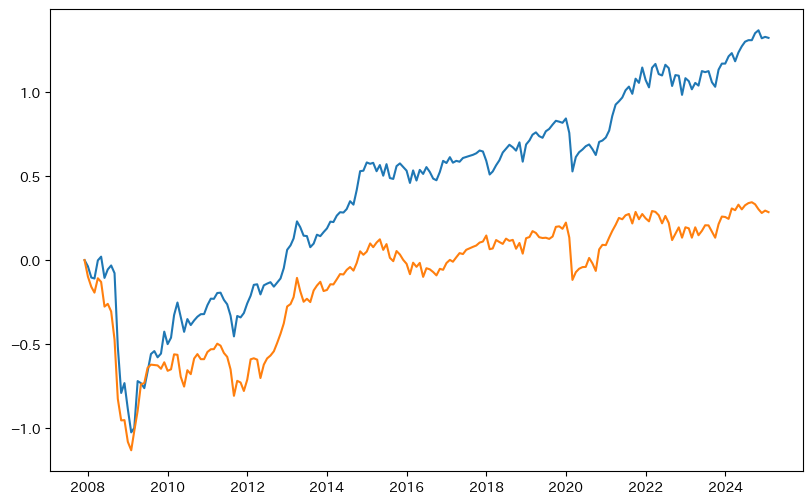

In [333]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(df['Date'], df['IYR_log_r'], label='IYR')
ax.plot(df['Date'], df['IFGL_log_r'], label='IFGL')

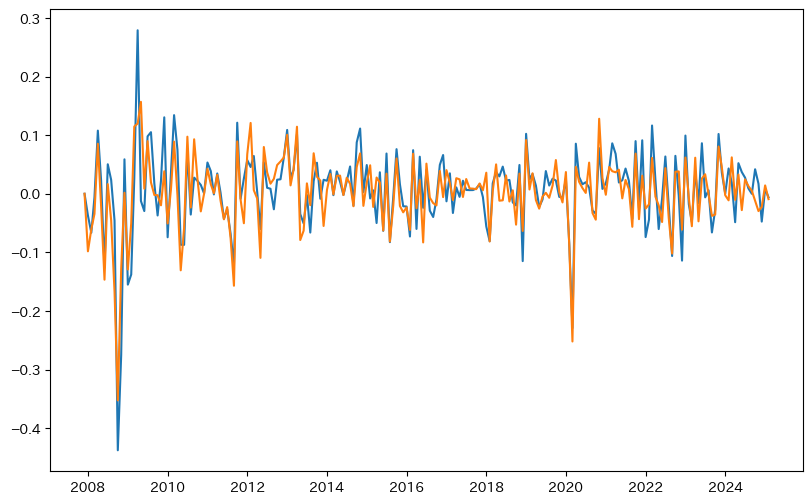

In [334]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(v_df['Date'], v_df['IYR_lr'], label='IYR')
ax.plot(v_df['Date'], v_df['IFGL_lr'], label='IFGL')

In [335]:
trade_days = 12
T = len(v_df) / trade_days
IYR_r = (df['IYR_close'][-1] / df['IYR_close'][0]) ** (1/T) - 1
IFGL_r = (df['IFGL_close'][-1] / df['IFGL_close'][0]) ** (1/T) - 1
print(f'IYR return: {IYR_r:.2%}')
print(f'IFGL return: {IFGL_r:.2%}')

IYR_vol = np.std(v_df['IYR_lr'].to_numpy()) * np.sqrt(trade_days)
IFGL_vol = np.std(v_df['IFGL_lr'].to_numpy()) * np.sqrt(trade_days)
print(f'IYR volatility: {IYR_vol:.2%}')
print(f'IFGL volatility: {IFGL_vol:.2%}')

IYR return: 7.96%
IFGL return: 1.67%
IYR volatility: 23.84%
IFGL volatility: 21.00%


In [336]:
w = np.array([0.3, 0.7])

r_p = w @ np.array([IYR_r, IFGL_r])
print(f'returm: {r_p:.2%}')

tmp = np.array([v_df['IYR_lr'], v_df['IFGL_lr']])
Sigma = np.cov(tmp)
sigma_p = np.sqrt(w.T @ Sigma @ w)
sigma_p_annual = sigma_p * np.sqrt(trade_days)
print(f'US: {w[0]:.0%}, exUS: {w[1]:.0%}')
print(f'Volatility: {sigma_p_annual:.2%}')


returm: 3.55%
US: 30%, exUS: 70%
Volatility: 21.00%


In [337]:
def calc_portfolio_volatility(w, v_df):
    tmp = np.array([v_df['IYR_lr'], v_df['IFGL_lr']])
    Sigma = np.cov(tmp)
    sigma_p_2 = w.T @ Sigma @ w
    sigma_p = np.sqrt(sigma_p_2)
    sigma_p_annual = sigma_p * np.sqrt(trade_days)
    return sigma_p_annual

wgh_list = [
    np.array([0, 1]),
    np.array([0.05, 0.95]),
    np.array([0.1, 0.9]),
    np.array([0.15, 0.85]),
    np.array([0.2, 0.8]),
    np.array([0.25, 0.75]),
    np.array([0.3, 0.7]),
    np.array([0.35, 0.65]),
    np.array([0.4, 0.6]),
    np.array([0.45, 0.55]),
    np.array([0.5, 0.5]),
    np.array([0.55, 0.45]),
    np.array([0.6, 0.4]),
    np.array([0.65, 0.35]),
    np.array([0.7, 0.3]),
    np.array([0.75, 0.25]),
    np.array([0.8, 0.2]),
    np.array([0.85, 0.15]),
    np.array([0.9, 0.1]),
    np.array([0.95, 0.05]),
    np.array([1, 0]),
]

return_list = [w @ np.array([IYR_r, IFGL_r]) for w in wgh_list]
sigma_list = [calc_portfolio_volatility(w, v_df) for w in wgh_list]

efficient_frontier = pl.DataFrame({
    'weight': [f'{w[0]:.0%} US' for w in wgh_list],
    'Return': return_list,
    'Volatility': sigma_list,
}).with_columns([
    (pl.col('Return') / pl.col('Volatility')).alias('SharpRatio')
])
efficient_frontier

weight,Return,Volatility,SharpRatio
str,f64,f64,f64
"""0% US""",0.016665,0.210507,0.079165
"""5% US""",0.01981,0.209859,0.094399
"""10% US""",0.022956,0.209439,0.109608
"""15% US""",0.026102,0.209247,0.124742
"""20% US""",0.029248,0.209285,0.139751
…,…,…,…
"""80% US""",0.066997,0.226871,0.295306
"""85% US""",0.070142,0.229637,0.305448
"""90% US""",0.073288,0.232577,0.315113


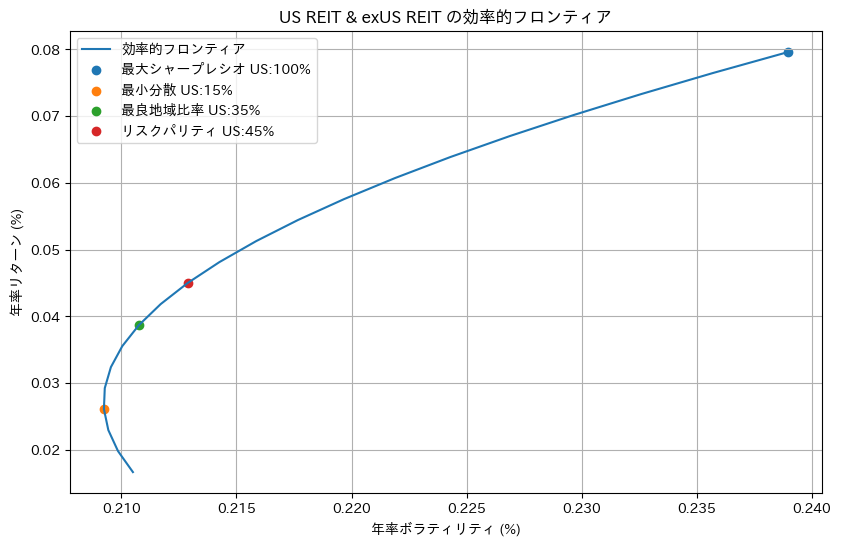

In [ ]:
max_sharp_ratio = efficient_frontier.filter(pl.col('SharpRatio') == efficient_frontier['SharpRatio'].max())
min_volatility = efficient_frontier.filter(pl.col('Volatility') == efficient_frontier['Volatility'].min())
us_35per = efficient_frontier.filter(pl.col('weight') == '35% US')
risk_parity = efficient_frontier.filter(pl.col('weight') == '45% US')

fig, ax = plt.subplots(figsize=(1.618*6, 6))
ax.plot(efficient_frontier['Volatility'], efficient_frontier['Return'], label='効率的フロンティア')
ax.scatter(max_sharp_ratio['Volatility'], max_sharp_ratio['Return'], label='最大シャープレシオ US:100%')
ax.scatter(min_volatility['Volatility'], min_volatility['Return'], label='最小分散 US:15%')
ax.scatter(us_35per['Volatility'], us_35per['Return'], label='最良地域比率 US:35%')
ax.scatter(risk_parity['Volatility'], risk_parity['Return'], label='リスクパリティ US:45%')
ax.set_xlabel('年率ボラティリティ (%)')
ax.set_ylabel('年率リターン (%)')
ax.set_title('US REIT & exUS REIT の効率的フロンティア')
ax.legend()
ax.grid(True)

In [363]:
inv_iyr_vol = 1 / IYR_vol
inv_ifgl_vol = 1 / IFGL_vol
sum_inv_vol = inv_iyr_vol + inv_ifgl_vol
iry_w = inv_iyr_vol / sum_inv_vol
ifgl_w = inv_ifgl_vol / sum_inv_vol
print(f'IYR weight: {iry_w:.2%}')
print(f'IFGL weight: {ifgl_w:.2%}')

print(f'US vol: {IYR_vol:.2%}')
print(f'exUS vol: {IFGL_vol:.2%}')
risk_parity_vol = risk_parity['Volatility'].to_numpy()[0]
print(f'Risk parity: {risk_parity_vol:.2%}')

IYR weight: 46.84%
IFGL weight: 53.16%
US vol: 23.84%
exUS vol: 21.00%
Risk parity: 21.29%
